In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.io

from skimage.filters import gabor_kernel

def gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, bounds):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    if bounds == 'auto':
        nstds = 3  # Number of standard deviation sigma
        xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
        ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
        #xmax = abs(nstds*sigma_x*np.cos(theta) + nstds*sigma_y*np.sin(theta))
        #ymax = abs(-nstds*sigma_x*np.sin(theta) + nstds*sigma_y*np.cos(theta))
        xmin = -xmax
        ymin = -ymax
    elif len(bounds)==4:
        xmin, xmax, ymin, ymax = bounds
    
    (x, y) = np.meshgrid(np.arange(xmin, xmax + x_step, x_step), np.arange(ymin, ymax + y_step, y_step))

    gauss = np.exp(-.5 * ((x*np.cos(theta) + y*np.sin(theta))**2/sigma_x**2 + (-x*np.sin(theta) + y*np.cos(theta))**2/sigma_y**2))
    wave = np.cos(2*np.pi/Lambda*(x*np.cos(theta)+y*np.sin(theta))+psi)
    gb = gauss * wave
    return gb, x, y


x_step = 0.002
y_step = 0.002
u0 = 0
v0 = 0.5    # or -8 to rotate the other way
psi = -np.pi    # -pi or -pi/2 or pi/2 
gamma = 1

if u0 != 0:
    theta = np.arctan(v0/u0)
else: 
    theta = np.pi/2

#f_x = np.linalg.norm([u0,v0])*np.cos(theta) = np.cos(theta)/Lambda

Lambda = 1/np.linalg.norm([u0,v0])
sigma = Lambda/1.5  # was Lambda/2
#x,y,g1 = gabor2(sigma, v0, u0, theta, gamma)
g1,x,y = gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')
#extent = [np.min(y), np.max(y), np.min(x), np.max(x)]   # Should be reversed now that x,y meshgrid is swapped ack

/tmp/ipykernel_710738/3388122117.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,g1)


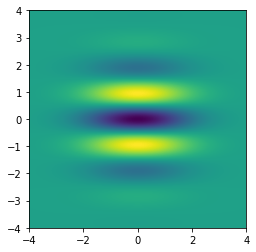

In [2]:
fig,ax = plt.subplots()
#ax = fig.add_subplot(projection='3d')

#ax.imshow(g1, cmap='hot')
#ax.imshow(g1, cmap='hot', extent=extent)
plt.pcolormesh(x,y,g1)
plt.axis('scaled')
plt.show()

# Looks inverted because imshow plots rows down on the "y"

In [3]:
# For 128 Hz, you can't really see the range of spectral, probably because they are all about 90 deg when only up to 8

display_scaled = True

if display_scaled:
    k_spect = np.array([0, 1, 2, 4, 8])  # cycles/octave
    k_temp = np.array([0, 4, 8, 16, 32, 64, 128])    # Hz
else:
    k_spect = np.array([0, 1, 2, 4])  # cycles/octave
    k_temp = np.array([0, 1, 2, 4])    # Hz

updown = [-1, 1]

max_sig_x = 1/min(k_temp[np.where(k_temp!=0)])*1/2
max_sig_y = 1/min(k_spect[np.where(k_spect!=0)])*1/2

if display_scaled is False:
    nstds = 2  # Number of standard deviation sigma
    xmax = nstds * max_sig_x
    ymax = nstds * max_sig_y
    xmin = -xmax
    ymin = -ymax
    bounds = [xmin, xmax, ymin, ymax]

gamma = 1.5    # Aspect ratio of Gaussian

ks_max = np.max(k_spect)
kt_max = np.max(k_temp)

x_step = min([1/kt_max/5, 1/ks_max*1/2*gamma/2])
y_step = min([1/ks_max/5, 1/kt_max*1/2/gamma/2])      # We can't just satisfy spectral wavelength, we also need to worry about gaussian aspect ratio

nfilts = len(k_spect)*len(k_temp)*len(updown)
print(nfilts)

print()

#fig,ax = plt.subplots(len(k_temp)*len(updown), len(k_spect), figsize=(15,24))
#fig,ax = plt.subplots(len(k_temp)*len(updown), len(k_spect), figsize=(5,10*(ymax-ymin)/(xmax-xmin)))
fig,ax = plt.subplots(len(k_spect), len(k_temp)*len(updown)-1, 
                      figsize=(12*(xmax-xmin)/(ymax-ymin)*(2*len(k_temp)-1)/len(k_spect),12))
# Yikes - looks like you have to run it display_scaled false first, then true to get proper figure scaling


# NEED TO RECALC XMAX XMIN

# How to store the set of filters - first just plot them
# Rewrite sigma in terms of both u0 and v0 norm

inds = np.concatenate((np.flip(np.arange(len(k_temp))), np.arange(len(k_temp))+len(k_temp)-1))

for i,ks in enumerate(k_spect):
    for j,kt in enumerate(k_temp):
        if (kt==0)&(ks==0):
            pass
        else:
            u0 = kt
            v0 = ks
            Lambda = 1/np.linalg.norm([u0,v0])
            sigma = Lambda/2
            if kt != 0:
                psi = np.cos(ks/kt)*np.pi/2
            else:
                psi = 0
                
            for k,ud in enumerate(updown):
                if u0 != 0:
                    theta = np.arctan(v0/u0)*ud
                else: 
                    theta = np.pi/2*ud
                if display_scaled:
                    x_step = Lambda/10
                    y_step = Lambda/10
                    g, x, y = gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')
                else:
                    g, x, y = gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, bounds)
                
                ax[-(i+1), inds[j+k*len(k_temp)]].pcolormesh(x,y,g)
                
                if (j == len(k_temp)-1) and (k == 0):
                    ax[-(i+1), inds[j+k*len(k_temp)]].set_ylabel('{0} cycles/oct'.format(ks))
                if i == 0:
                    ax[-(i+1), inds[j+k*len(k_temp)]].set_xlabel('{0} cycles/sec'.format(kt))
                #plt.axis('scaled')
                #ax[inds[i+k*len(k_temp)],j+k*len(k_temp)].set_xticks([])
                #ax[inds[i+k*len(k_temp)],j+k*len(k_temp)].set_yticks([])

#fig.supxlabel('Spectral modulation frequency ([0, 0.5, 1, 2, 4, 8] cycles/oct)')
#fig.supylabel('Temporal modulation frequency ([0, 2, 4, 8, 16, 32, 64, 128] Hz)')
fig.tight_layout()

# Looks inverted because imshow plots rows down on the "y"
        
#        for ps in psi:
#            for ud in updown:
#                if ks != 0:
#                    theta = np.arctan(kt/ks)
#                else: 
#                    theta = np.pi/2
#                kt = kt*ps
#                Lambda = 1/np.linalg.norm([kt,ks])
#                g1 = gabor(sigma, theta, Lambda, ps, gamma)
#                ax.imshow(g1, cmap='hot')

plt.show()

        

70



NameError: name 'xmax' is not defined

In [4]:
inds = np.concatenate((np.flip(np.arange(len(k_temp))), np.arange(len(k_temp))+len(k_temp)-1))
inds


array([ 6,  5,  4,  3,  2,  1,  0,  6,  7,  8,  9, 10, 11, 12])

In [4]:
u0 = 128
v0 = 0

if u0 != 0:
    theta = np.arctan(v0/u0)
else: 
    theta = np.pi/2
Lambda = 1/np.linalg.norm([u0,v0])
sigma = 2*Lambda/3

g, x, y = gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')

/tmp/ipykernel_710738/2143284621.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,g)


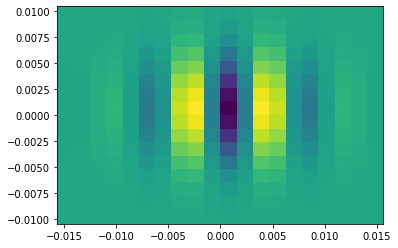

In [5]:
fig,ax = plt.subplots()
plt.pcolormesh(x,y,g)
plt.axis('scaled')
plt.show()


In [2]:
import scipy.io
import numpy as np
#import sounddevice as sd
from IPython.display import Audio
from scipy.io.wavfile import write

mat = scipy.io.loadmat('/home/ping/Filternet_improvement/ucsf_timit_sents.mat')

#len(mat.timit_sents

print(mat['timit_sents'].shape)

data = np.squeeze(mat['timit_sents'][0,7])
print(mat['timit_sents'].shape)

sr = mat['aud_fs'][0][0]
print(sr)

scaled = np.int16(data / np.max(np.abs(data)) * 32767)
print(scaled.shape)

#scaled = np.int16(sent1 * 32767)
write('/home/ping/Filternet_improvement/ucsf_timit_sent0.wav', sr, scaled)

#Audio(scaled, rate=mat['aud_fs'])

(1, 200)
(1, 200)
16000
(35328,)


SR: 16000
here
[0.00000000e+00 3.29638634e-01 6.59277267e-01 ... 7.99934072e+03
 7.99967036e+03 8.00000000e+03]
(24270,)
length of t: (48538,)
[   0. 1000. 2000. 3000. 4000. 5000. 6000. 7000. 8000.]
[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]
fracs: [0.         0.13657605 0.2731521  0.40972814 0.54630419 0.68288024
 0.81945629 0.98463865]
locs: [  50.         1135.77957841 2221.55915682 3307.33873522 4393.11831363
 5478.89789204 6564.67747045 7877.87723588]
48538
16000
30
4
None


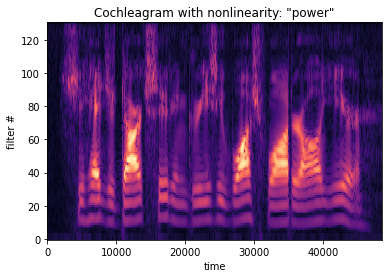

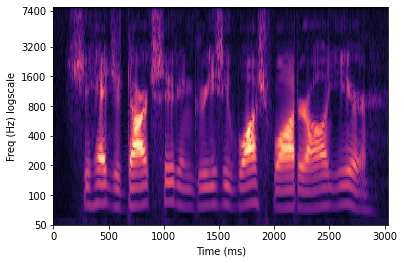

In [26]:
from pycochleagram import cochleagram as cgram
from pycochleagram import erbfilter as erb
from pycochleagram import utils

low_lim = 50 
hi_lim = 8000
# look for "Running demo with sound file: <rfn>
rfn = '/home/ping/pycochleagram/pycochleagram/demo_stim/sa1.wav'
#rfn = '/home/ping/Filternet_improvement/ucsf_timit_sent0.wav'
#rfn = '/home/ping/Filternet_improvement/203_Hz_pure_tone.wav'
#rfn = '/home/ping/Filternet_improvement/FM_sweep_stim.wav'
demo_stim, demo_sr = utils.wav_to_array(rfn)
print('SR:', demo_sr)
#demo_n = 38  # default filter for low_lim=50 hi_lim=20000
n = int(np.floor(erb.freq2erb(hi_lim) - erb.freq2erb(low_lim)) - 1)
sr = demo_sr
signal = demo_stim
sample_factor = 4    # density of sampling, can be 1,2, or 4
downsample= None

human_coch = cgram.human_cochleagram(signal, sr, n=n, sample_factor=sample_factor,
      downsample=downsample, nonlinearity="power", strict=False)

img = np.flipud(human_coch)  # the cochleagram is upside down (i.e., in image coordinates)

t = np.arange(0, 1/sr*human_coch.shape[1], 1/sr)
print("length of t:", t.shape)
fig,ax = plt.subplots()
ax.set_title('Cochleagram with nonlinearity: "power"')
ax.set_ylabel('filter #')
ax.set_xlabel('time')
utils.cochshow(np.flipud(img), interact=False)
#ax.invert_yaxis()   # Looks upside down, although it matches the demo

fig,ax = plt.subplots()
#ax.imshow(human_coch, aspect='auto', cmap='magma')
ax.imshow(human_coch, aspect='auto', cmap='magma', origin='lower', interpolation='nearest', 
          extent=[0,human_coch.shape[1]/sr*1000, low_lim, hi_lim])

#ax.pcolor(t,log_freqs,human_coch, cmap='magma')
#ax.set_yscale('log')
# Run next box first to get log freqs

locs,labels = plt.yticks()
nlocs = len(locs)
print(locs)
#locs[0] = low_lim
#locs[-1] = hi_lim
print(labels)
labels = labels[:-1]   # Trim off extra labels
#actual_locs = np.geomspace(low_lim,hi_lim,nlocs)
actual_locs = [50, 100, 200, 400, 800, 1600, 3200, 7400]
fracs = np.log2(np.array(actual_locs)/50)/(np.log2(hi_lim/low_lim))
print("fracs:", fracs)
locs = fracs*(hi_lim-low_lim)+low_lim
print("locs:", locs)

for i, label in enumerate(labels):
    label.set_text("{0:.0f}".format(actual_locs[i]))
plt.yticks(locs, labels)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Freq (Hz) logscale')

print(len(signal))
print(sr)
print(n)
print(sample_factor)
print(downsample)

[  50.           51.99059329   54.06043582   56.21268264   58.45061442
   60.77764244   63.19731379   65.71331677   68.32948652   71.04981087
   73.87843641   76.81967481   79.8780094    83.058102     86.36480001
   89.80314385   93.37837456   97.09594188  100.9615125   104.98097869
  109.16046733  113.50634922  118.02524876  122.72405414  127.60992772
  132.69031704  137.97296615  143.46592737  149.17757362  155.11661117
  161.29209289  167.71343206  174.39041672  181.33322459  188.55243861
  196.059063    203.86454012  211.98076784  220.42011774  229.1954539
  238.32015257  247.80812251  257.67382624  267.93230205  278.59918692
  289.69074038  301.22386928  313.21615355  325.68587304  338.65203533
  352.13440474  366.15353243  380.73078774  395.88839079  411.6494463
  428.03797884  445.07896944  462.79839367  481.22326124  500.38165716
  520.30278458  541.01700924  562.55590585  584.95230611  608.24034885
  632.45553203  657.63476684  683.81643396  711.0404421   739.34828881
  768.78

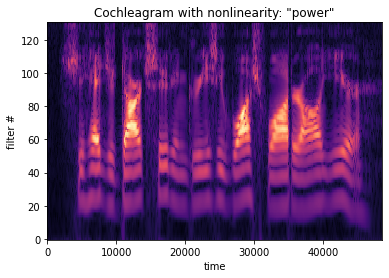

In [3]:
# Use this for interpolated
#desired_sr = 1000
#human_coch = scipy.signal.resample_poly(human_coch, desired_sr, sr, axis=1)

padding_size = None
downsample=None
nonlinearity='power'
fft_mode='auto'
ret_mode='envs'
strict=False
erb_kwargs = {}   # confirmed with print
    
#filts, hz_cutoffs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],

filts, center_freqs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],
      sr, n, low_lim, hi_lim, sample_factor, padding_size=padding_size,
      full_filter=True, strict=strict, **erb_kwargs)

log_freqs = np.geomspace(low_lim, hi_lim, len(center_freqs))

from scipy.interpolate import interp1d 

#log_freqs = log_freqs[np.where((log_freqs<hi_lim)&(log_freqs>low_lim))]

n_t = img.shape[1]
Ytf = np.empty((len(log_freqs), n_t))
for i in range(n_t):
    f = interp1d(np.log2(center_freqs/50), human_coch[:,i], kind='cubic')
    Ytf[:,i] = f(np.log2(log_freqs/50)) 

print(log_freqs)
print(len(log_freqs))
    
fig,ax = plt.subplots()

ax.set_title('Cochleagram with nonlinearity: "power"')
ax.set_ylabel('filter #')
ax.set_xlabel('time')
utils.cochshow(Ytf, interact=False)

#ax.imshow(Ytf, aspect='auto')

In [55]:
print(center_freqs)

[  28.07557025   35.18516025   42.49148877   50.           57.71628881
   65.64610486   73.79535695   82.17011737   90.77662645   99.6212972
  108.71072009  118.05166797  127.65110111  137.51617239  147.65423261
  158.072836    168.77974583  179.78294019  191.09061795  202.71120486
  214.65335982  226.92598135  239.53821422  252.49945624  265.81936528
  279.50786649  293.57515963  308.03172676  322.88833995  338.15606941
  353.84629164  369.97069798  386.5413033   403.57045493  421.0708419
  439.05550435  457.5378433   476.53163057  496.05101911  516.11055349
  536.72518079  557.91026169  579.68158192  602.05536408  625.04827964
  648.67746144  672.96051641  697.9155387   723.56112319  749.91637929
  777.00094524  804.83500269  833.43929177  862.83512655  893.0444109
  924.08965481  955.99399119  988.78119307 1022.47569136 1057.102593
 1092.68769972 1129.25752722 1166.83932498 1205.46109651 1245.15162024
 1285.94047098 1327.85804193 1370.93556735 1415.20514582 1460.69976415
 1507.45332

(array([1004473., 1342482.,  679156.,  309265.,  211052.,  144695.,
          70111.,   30244.,   11693.,    6571.]),
 array([0.00681682, 0.07260381, 0.13839079, 0.20417777, 0.26996475,
        0.33575173, 0.40153872, 0.4673257 , 0.53311268, 0.59889966,
        0.66468664]),
 <BarContainer object of 10 artists>)

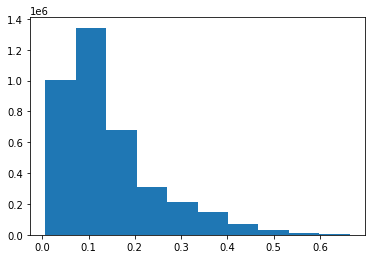

In [10]:
plt.hist(human_coch.flatten())
#np.min(human_coch)
#np.min(np.log(human_coch.flatten()))
#plt.plot(np.max(human_coch, axis=0))

29082


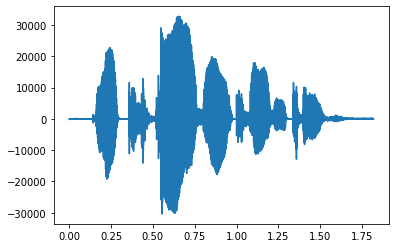

In [11]:
from scipy.io.wavfile import read
rate,data = read(rfn)
t = np.arange(0, 1/rate*len(data), 1/rate)
print(len(t))
plt.plot(t, data)

131


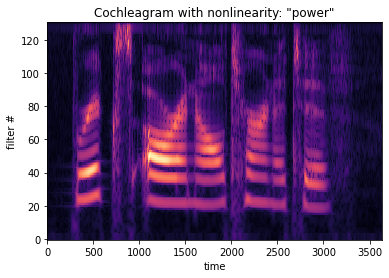

In [7]:
#np.min(human_coch)
#num = human_coch.shape[1]*4000/16000
#np.floor(num)*sr/human_coch.shape[1]
desired_sr = 2000
human_coch = scipy.signal.resample_poly(human_coch, desired_sr, sr, axis=1)

padding_size = None
downsample=None
nonlinearity='power'
fft_mode='auto'
ret_mode='envs'
strict=False
erb_kwargs = {}   # confirmed with print
    
#filts, hz_cutoffs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],

filts, center_freqs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],
      sr, n, low_lim, hi_lim, sample_factor, padding_size=padding_size,
      full_filter=True, strict=strict, **erb_kwargs)

img = np.flipud(human_coch)  # the cochleagram is upside down (i.e., in image coordinates)

fig,ax = plt.subplots()
ax.set_title('Cochleagram with nonlinearity: "power"')
ax.set_ylabel('filter #')
ax.set_xlabel('time')
utils.cochshow(np.flipud(img), interact=False)
#ax.invert_yaxis()   # Looks upside down, although it matches the demo

print(human_coch.shape[0])

In [96]:
np.where(human_coch>0.59)

(array([125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126,
        126, 127, 127, 127, 127, 127, 127, 127, 127, 127]),
 array([1112, 1113, 1114, 1115, 1116, 1114, 1115, 1116, 1117, 1118, 1119,
        1120, 1121, 1122, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122,
        1123]))

In [98]:
human_coch.shape[0]

327

In [8]:
padding_size = None
downsample=None
nonlinearity='power'
fft_mode='auto'
ret_mode='envs'
strict=False
erb_kwargs = {}   # confirmed with print
    
#filts, hz_cutoffs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],

filts, center_freqs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],
      sr, n, low_lim, hi_lim, sample_factor, padding_size=padding_size,
      full_filter=True, strict=strict, **erb_kwargs)

In [14]:
log_freqs = np.geomspace(np.min(center_freqs), np.max(center_freqs), len(center_freqs))

In [22]:
print(log_freqs)

[  40.           40.68620945   41.38419098   42.09414656   42.81628159
   43.55080501   44.29792936   45.05787081   45.83084922   46.61708827
   47.41681543   48.2302621    49.05766364   49.89925945   50.75529304
   51.62601208   52.51166851   53.41251859   54.32882297   55.26084676
   56.20885964   57.17313591   58.15395456   59.15159939   60.16635905
   61.19852716   62.24840235   63.3162884    64.40249428   65.50733429
   66.63112808   67.77420083   68.93688325   70.11951177   71.32242856
   72.54598167   73.79052513   75.05641902   76.34402962   77.65372948
   78.98589756   80.34091929   81.71918674   83.1210987    84.54706078
   85.99748558   87.47279276   88.97340919   90.49976904   92.05231396
   93.63149316   95.23776354   96.87158987   98.53344488  100.22380941
  101.94317254  103.69203175  105.47089305  107.28027113  109.12068953
  110.99268074  112.8967864   114.83355744  116.80355425  118.80734682
  120.84551492  122.91864828  125.02734673  127.1722204   129.35388988
  131.

In [9]:
from scipy.interpolate import interp1d 

#log_freqs = np.geomspace(20, 20480, 101)
#log_freqs = np.geomspace(40, 10240, 327)
log_freqs = np.geomspace(40, 10240, 327)
log_freqs = log_freqs[np.where((log_freqs<np.max(center_freqs))&(log_freqs>np.min(center_freqs)))]

n_t = img.shape[1]
Ytf = np.empty((len(log_freqs), n_t))
for i in range(n_t):
    f = interp1d(np.log2(center_freqs), img[:,i], kind='cubic')
    Ytf[:,i] = f(np.log2(log_freqs)) 


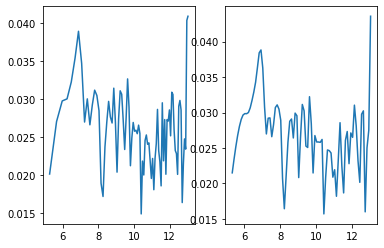

In [5]:
#i = 1000
#n_t = img.shape[1]
#Ytf = np.empty((len(log_freqs), n_t))
#log_freqs = log_freqs[np.where((log_freqs<np.max(center_freqs))&(log_freqs>np.min(center_freqs)))]
#f = interp1d(np.log2(center_freqs), img[:,i], kind='cubic', bounds_error=False, fill_value= 'extrapolate')
#fig, ax = plt.subplots(1,2)
#ax[0].plot(np.log2(center_freqs), img[:,i])
#nans = np.where(np.isnan(img))   # appears free of nans
#Ytf[:,i] = f(np.log2(log_freqs)) 
#ax[1].plot(np.log2(log_freqs), Ytf[:,i])



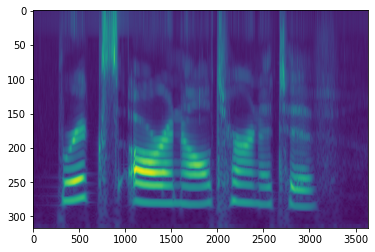

In [10]:
fig, ax = plt.subplots()
ax.imshow(Ytf, aspect='auto')
#utils.cochshow(np.flipud(Ytf), interact=False)

img = Ytf

In [12]:
img.shape
img = img[...,np.newaxis]
img.shape

(317, 3636, 1)

In [13]:
from skimage import data
from skimage.transform import pyramid_gaussian

image = img
rows, cols, dim = image.shape
pyramid = tuple(pyramid_gaussian(image, downscale=2, channel_axis=None))
#pyramid = tuple(pyramid_gaussian(image, downscale=2, channel_axis=-1))    # For multiple channels, e.g., 3 channel color

composite_image = np.zeros((rows, cols + cols // 2, dim), dtype=np.double)

composite_image[:rows, :cols, :] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

ValueError: could not broadcast input array from shape (2,15,1) into shape (0,15,1)

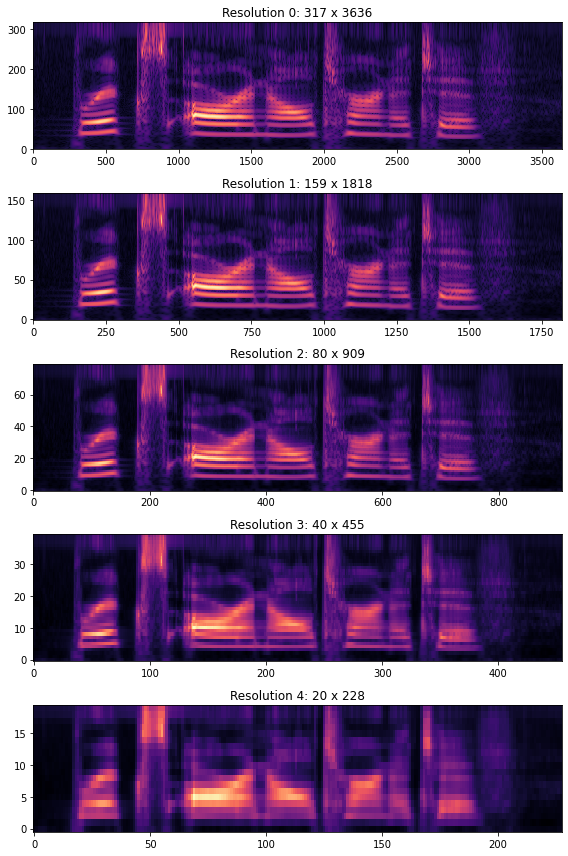

In [14]:
fig, ax = plt.subplots(5,1, figsize=(8,12))

for i in range(5):
    plt.axes(ax[i])
    utils.cochshow(np.flipud(pyramid[i]), interact=False)
    tit_str = 'Resolution {0}: {1} x {2}'.format(i, pyramid[i].shape[0], pyramid[i].shape[1])
    ax[i].set_title(tit_str)
    pyramid[i].shape

fig.tight_layout()


In [15]:
def gabor2(sigma, theta, Lambda, psi, gamma, x_step, y_step, bounds, scx=1):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    if bounds == 'auto':
        nstds = 2.5  # Number of standard deviation sigma
        xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
        ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
        #xmax = abs(nstds*sigma_x*np.cos(theta) + nstds*sigma_y*np.sin(theta))
        #ymax = abs(-nstds*sigma_x*np.sin(theta) + nstds*sigma_y*np.cos(theta))
        #xmax = xmax*scx
        xmin = -xmax
        ymin = -ymax
    elif len(bounds)==4:
        xmin, xmax, ymin, ymax = bounds
    #x_step = x_step/scx
    
    (x, y) = np.meshgrid(np.arange(xmin, xmax + x_step, x_step), np.arange(ymin, ymax + y_step, y_step))
    #x = x/scx
    gauss = np.exp(-.5 * ((x*np.cos(theta) + y*np.sin(theta))**2/sigma_x**2 + (-x*np.sin(theta) + y*np.cos(theta))**2/sigma_y**2))
    wave = np.cos(2*np.pi/Lambda*(x*np.cos(theta)+y*np.sin(theta))+psi)
    gb = gauss * wave

    return gb, x, y

(14, 26)
(14, 23)
(23, 14)
(26, 14)
(14, 26)
(14, 23)
(23, 14)
(26, 14)
(14, 26)
(14, 23)
(23, 14)
(26, 14)
(14, 26)
(14, 23)
(23, 14)
(26, 14)
(14, 26)
(14, 23)
(23, 14)
(26, 14)


/tmp/ipykernel_710738/2550361961.py:53: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i,j+k*(len(theta_set)*2-2)].pcolormesh(x,y,g)
/tmp/ipykernel_710738/2550361961.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i, 2*len(theta_set)-2-j +k*(len(theta_set)*2-2)].pcolormesh(x,y,g2)


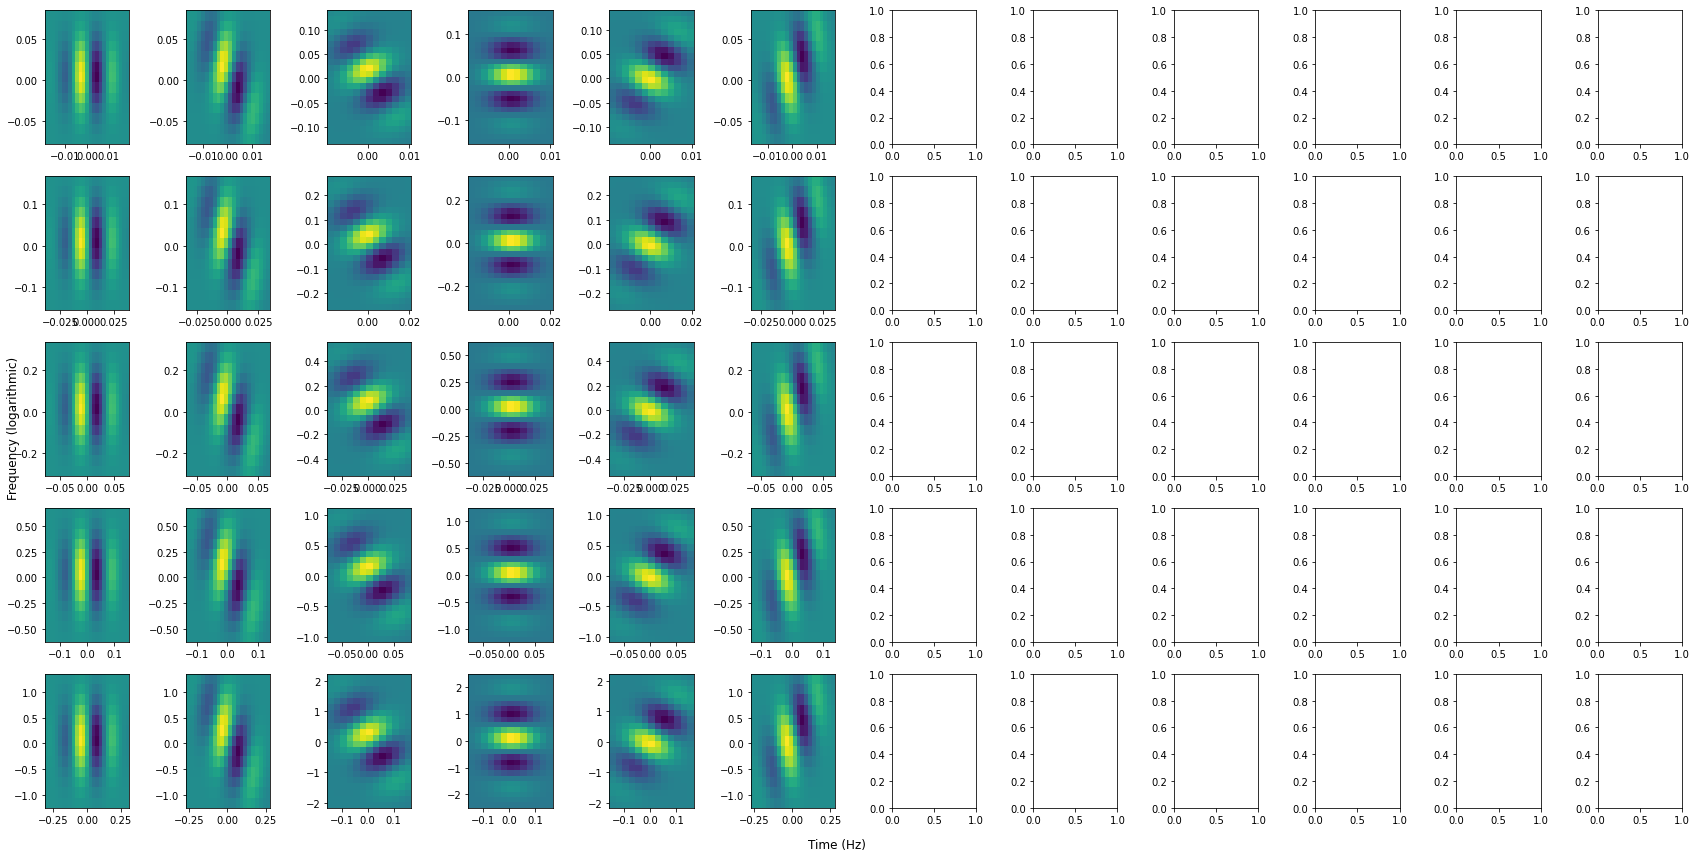

In [16]:
#k_spect = np.array([0.5, 1, 2, 4, 8])  # cycles/octave
#k_temp = np.array([4, 8, 16, 32, 64])    # Hz

# Scale by 8 to arrive at filter? but in normal coordinates?
# 0 appears in each set
# five sets of resolution

# Reflect to get down going
# 7 angles * 5 scales = 35 filters

theta_set = [0, -np.pi/6, -np.pi/3, np.pi/2]
lambda_set = [0.125, 0.25, 0.5, 1, 2]
# Corresponds to spectral freq 8 Hz to 0.5 Hz
# Corresponds to temporal freq 64 Hz to 4 Hz
scx = 8
display_scaled = True

bounds = [-np.max(lambda_set), np.max(lambda_set), -np.max(lambda_set), np.max(lambda_set)]

#gamma_list = [2, 1]    # Aspect ratio of Gaussian
gamma_list = [2]

x_step = min([np.min(lambda_set)/5/scx, np.max(lambda_set)*1/2*gamma/2/scx])
y_step = min([np.min(lambda_set)/5, np.max(lambda_set)*1/2/gamma/2]) 

#x_step = 1/np.min(lambda_set)/8
#y_step = 1/np.min(lambda_set)/8

fig,ax = plt.subplots(len(lambda_set), 2*(len(theta_set)*2-2),  
#                      figsize=(12*(xmax-xmin)/(ymax-ymin)*(2*len(theta_set)-2)*2/len(lambda_set)/scx,12))
                       figsize=(24,12))

# How to store the set of filters - first just plot them
# Rewrite sigma in terms of both u0 and v0 norm

#inds = np.concatenate((np.flip(np.arange(len(k_temp))), np.arange(len(k_temp))+len(k_temp)-1))

all_filts = np.empty((len(lambda_set),len(theta_set)), object)

for i,Lambda in enumerate(lambda_set):
    for j,theta in enumerate(theta_set):
        for k,gamma in enumerate(gamma_list):
            sigma = Lambda/2
            psi = np.cos(theta)*np.pi/2
            if display_scaled:
                x_step = Lambda/10
                y_step = Lambda/10
                g, x, y = gabor2(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')
                print(g.shape)
            else:
                g, x, y = gabor2(sigma, theta, Lambda, psi, gamma, x_step, y_step, bounds)
            x = x/scx    
            ax[i,j+k*(len(theta_set)*2-2)].pcolormesh(x,y,g)
            all_filts[i,j] = g
            if theta != 0 and theta != np.pi/2:
                g2 = np.flipud(g)
                ax[i, 2*len(theta_set)-2-j +k*(len(theta_set)*2-2)].pcolormesh(x,y,g2)
        
        #plt.axis('scaled')

fig.supylabel('Frequency (logarithmic)')
fig.supxlabel('Time (Hz)')
fig.tight_layout()


(31, 501)
-0.015625
6.237524950099805e-05
0.000125
(27, 435)
-0.013531646934131855
6.235632183908052e-05
0.000125
(27, 435)
-0.013531646934131853
6.235632183908052e-05
0.000125
(31, 501)
-0.015625
6.237524950099805e-05
0.000125
(31, 501)
-0.03125
0.0001247504990019961
0.00025
(27, 435)
-0.02706329386826371
0.00012471264367816103
0.00025
(27, 435)
-0.027063293868263706
0.00012471264367816103
0.00025
(31, 501)
-0.03125
0.0001247504990019961
0.00025
(31, 501)
-0.0625
0.0002495009980039922
0.0005
(27, 435)
-0.05412658773652742
0.00024942528735632206
0.0005
(27, 435)
-0.05412658773652741
0.00024942528735632206
0.0005
(31, 501)
-0.0625
0.0002495009980039922
0.0005
(31, 501)
-0.125
0.0004990019960079844
0.001
(27, 435)
-0.10825317547305484
0.0004988505747126441
0.001
(27, 435)
-0.10825317547305482
0.0004988505747126441
0.001
(31, 501)
-0.125
0.0004990019960079844
0.001
(31, 501)
-0.25
0.0009980039920159688
0.002
(27, 435)
-0.21650635094610968
0.0009977011494252883
0.002
(27, 435)
-0.216506350

/tmp/ipykernel_710738/2306840011.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i,j+k*(len(theta_set)*2-2)].pcolormesh(x,y,g)   # ARE THE X,Y Correct for all?
/tmp/ipykernel_710738/2306840011.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i, 2*len(theta_set)-2-j +k*(len(theta_set)*2-2)].pcolormesh(x,y,g2)


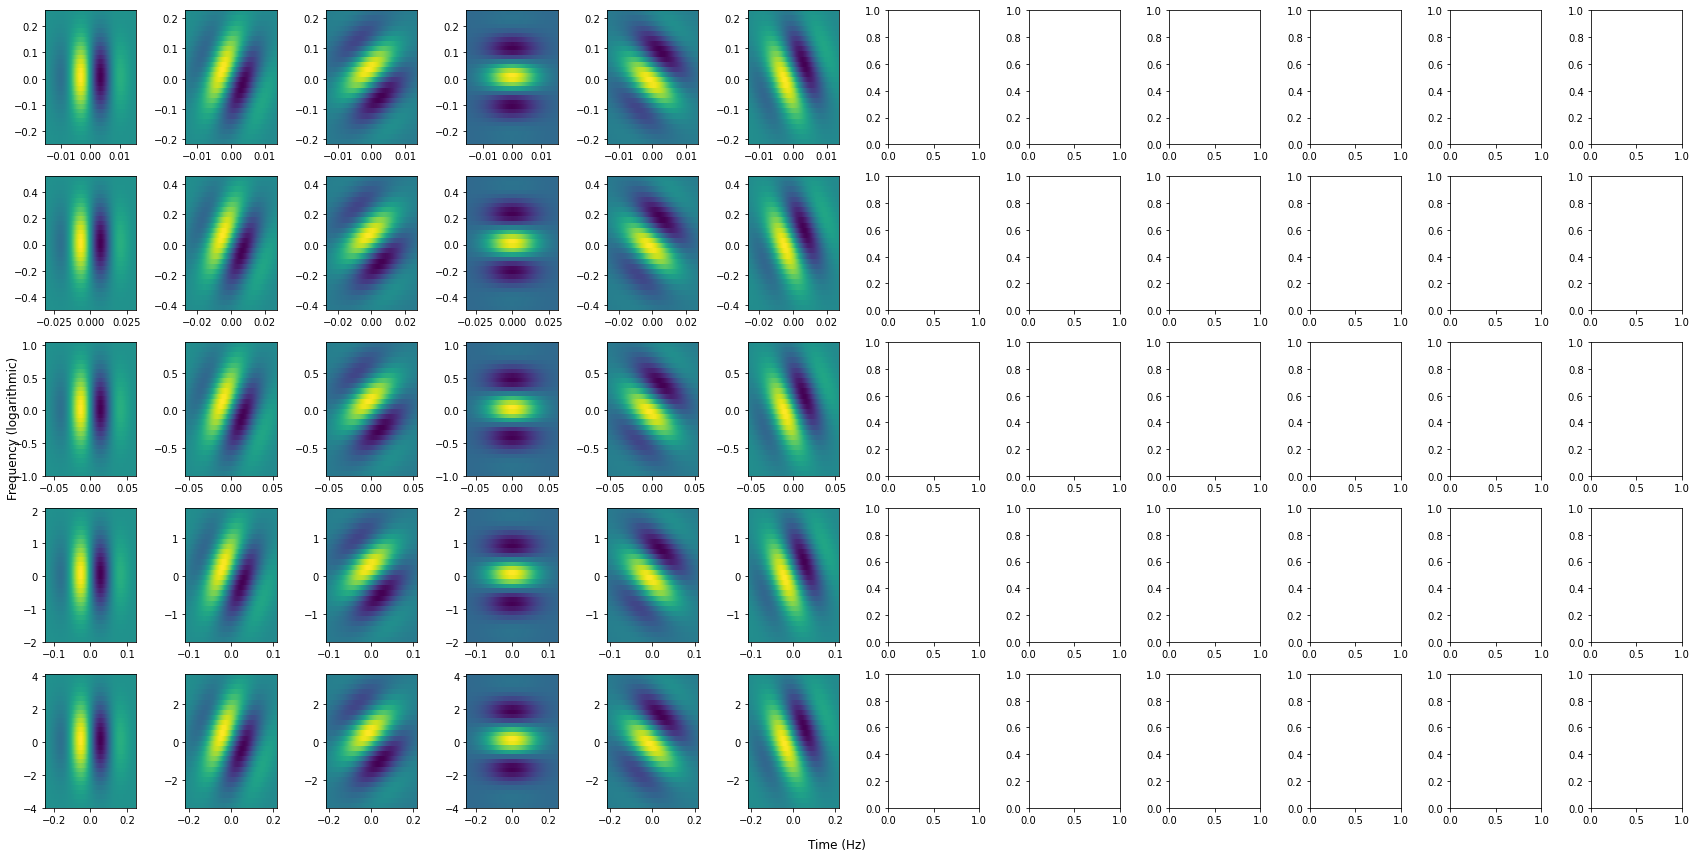

In [20]:
# Resolution matched to cochleagram

#k_spect = np.array([0.5, 1, 2, 4, 8])  # cycles/octave
#k_temp = np.array([4, 8, 16, 32, 64])    # Hz

# Scale by 8 to arrive at filter? but in normal coordinates?
# 0 appears in each set
# five sets of resolution

# Reflect to get down going
# 7 angles * 5 scales = 35 filters

theta_set = [0, -np.pi/6, -np.pi/3, np.pi/2]
#lambda_set = [0.125, 0.25, 0.5, 1, 2]
lambda_set = [0.25, 0.5, 1, 2, 4]

# Corresponds to spectral freq 8 Hz to 0.5 Hz
# Corresponds to temporal freq 64 Hz to 4 Hz
scx = 16   # was 8
display_scaled = True

bounds = [-np.max(lambda_set), np.max(lambda_set), -np.max(lambda_set), np.max(lambda_set)]

#gamma_list = [2, 1]    # Aspect ratio of Gaussian
gamma_list=[1]

y_step_base = np.diff(np.log(log_freqs))[0]
x_step_base = 1/sr*scx

fig,ax = plt.subplots(len(lambda_set), 2*(len(theta_set)*2-2),  
#                      figsize=(12*(xmax-xmin)/(ymax-ymin)*(2*len(theta_set)-2)*2/len(lambda_set)/scx,12))
                       figsize=(24,12))

# How to store the set of filters - first just plot them
# Rewrite sigma in terms of both u0 and v0 norm

#inds = np.concatenate((np.flip(np.arange(len(k_temp))), np.arange(len(k_temp))+len(k_temp)-1))

all_filts = np.empty((len(lambda_set),len(theta_set)*2-2), object)

for i,Lambda in enumerate(lambda_set):
    for j,theta in enumerate(theta_set):
        for k,gamma in enumerate(gamma_list):
            sigma = Lambda/2.5
            psi = np.cos(theta)*np.pi/2
            if display_scaled:
                x_step = x_step_base*(2**i)
                y_step = y_step_base*(2**i)
                g, x, y = gabor2(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')
                print(g.shape)
            else:
                g, x, y = gabor2(sigma, theta, Lambda, psi, gamma, x_step_base, y_step_base, bounds)
            x = x/scx    
            print(x.min())
            print((x.max()-x.min())/(x.shape[1]))
            print(x_step/8)
            ax[i,j+k*(len(theta_set)*2-2)].pcolormesh(x,y,g)   # ARE THE X,Y Correct for all?
            all_filts[i,j] = g
            if theta != 0 and theta != np.pi/2:
                g2 = np.flipud(g)
                ax[i, 2*len(theta_set)-2-j +k*(len(theta_set)*2-2)].pcolormesh(x,y,g2)
                all_filts[i,2*len(theta_set)-2-j] = g2
        
        #plt.axis('scaled')

fig.supylabel('Frequency (logarithmic)')
fig.supxlabel('Time (Hz)')
fig.tight_layout()



In [22]:
1/16000   # Yes, the resolutions check, final time resolution

6.25e-05

In [23]:
1/16000*2*2   *2*2*2*2   # final scale has a reasonable time resolution

0.004

In [24]:
x_step_base

0.001

In [21]:
print(all_filts[0,0].max())
print(all_filts[0,2].max())
print(all_filts[1,0].max())
print(all_filts[0,3].max())

# because of phase (cos phase aligns peaks), there is some diff across filters, but not across scale?

0.892639829595022
0.9638851364317514
0.892639829595022
0.9997853584151962


In [25]:
#jfilt = 80-70
jfilt = 80-22
#jfilt = 54 for ifilt 3 scale 0
# Beware flipud when indexing
print(resp.shape)
resp_d, times_d = scipy.signal.resample(resp,int(resp.shape[1]/(2**(4-scale))), t=times, axis=1)
print(resp_d.shape)
fig,ax = plt.subplots(2,1)
ax[0].plot(times,resp[jfilt,:])
ax[1].plot(times_d,resp_d[jfilt,:])
# Should this go through a rectify?

# You shouldn't zero pad in freq either then? artificially creates an edge?

(80, 909)


NameError: name 'times' is not defined

In [26]:
from bmtk.analyzer.spike_trains import plot_raster
from bmtk.builder.networks import NetworkBuilder

thalamus = NetworkBuilder('mthalamus')
thalamus.add_nodes(
    N=10,
    pop_name='tON',
    potential='exc',
    model_type='virtual'
)

thalamus.build()
thalamus.save_nodes(output_dir='/home/ping/Filternet_improvement/network')


def reLU (signal, bendpoint, slope):
    signal_out = np.empty_like(signal)
    signal_out[signal<bendpoint]= 0
    signal_out[signal>=bendpoint]=signal[signal>=bendpoint]-bendpoint
    signal_out[signal_out>=0]*=slope
    return signal_out

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


# Test ReLU
#signa = np.arange(0,10,0.1)
#output2 = reLU(signa,1,2)
#plt.plot(signa,output2)

# Should we rectify? Yes, see filternet diagram
C = 5
A = 1

input = C+resp_d[jfilt,:]*A
# Rectify
output = reLU(input, 1, 1.0)

#print(output.min())
#print(output.shape)
#print(times.shape)

from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

psg = PoissonSpikeGenerator(population='mthalamus')
psg.add(
    node_ids=range(10),  # Have 10 nodes to match mthalamus
    firing_rate=output,    # 10 Hz, we can also pass in a nonhomoegenous function/array
    times=times_d          # 
)

#fn = 
fn = '/home/ping/Filternet_improvement/test_spikes.h5'
psg.to_sonata(fn)

plt.plot(times_d, output)

_ = plot_raster(spikes_file=fn)



NameError: name 'resp_d' is not defined

(80, 909, 1)
(110, 1409, 1)


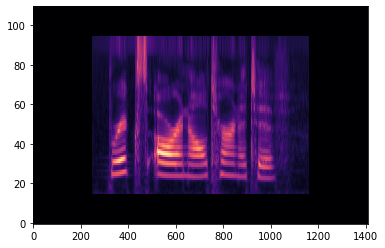

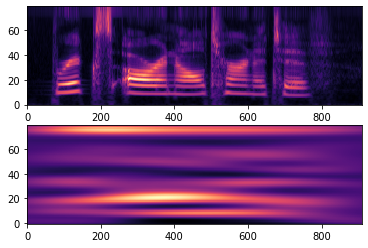

(80, 909)

In [27]:
#all_filts[0,0].shape
#np.convolve(pyramid[0], all_filts[0,0])
#resp = scipy.signal.convolve(np.squeeze(pyramid[0]),all_filts[0,0], mode='same')
scale = 2
# test out scale = 4
#ifilt = 0
ifilt = 3

# Pads with edge - assumes nothing funky happening at edge of signal

pad_size = all_filts[scale,ifilt].shape[1]-1
#pad_size = 8000 # To visualize
pad_size_bef = int(np.ceil(pad_size/2))
pad_size_aft = pad_size - pad_size_bef

pad_size2 = all_filts[scale,ifilt].shape[0]-1
pad_size_bef2 = int(np.ceil(pad_size2/2))
pad_size_aft2 = pad_size2 - pad_size_bef2

npad = [(0, 0)] * pyramid[scale].ndim
npad[0] = (pad_size_bef2, pad_size_aft2)
npad[1] = (pad_size_bef, pad_size_aft)
#padded_coch = np.pad(pyramid[scale],pad_width=npad, mode='edge')
padded_coch = np.pad(pyramid[scale],pad_width=npad, mode='constant')

utils.cochshow(np.flipud(padded_coch), interact=False)
print(pyramid[scale].shape)
print(padded_coch.shape)

resp = scipy.signal.convolve(np.squeeze(padded_coch),all_filts[scale,ifilt], mode='valid')

# Get edge artifacts if unpadded

resp_norm = resp/resp.max()
y_step = y_step_base*(2**scale)
x_step = x_step_base*(2**scale)/scx
times = np.arange(0,resp_norm.shape[1]*x_step, x_step)
freq_start = np.mean(np.log(log_freqs[0:2**scale]))
freqs = np.exp(np.arange(freq_start,freq_start+y_step*resp_norm.shape[0], y_step))


(x, y) = np.meshgrid(times, freqs)
#(x, y) = np.meshgrid(np.linspace(0, 20000, resp_norm.shape[1]), np.linspace(0, 5000, resp_norm.shape[0]))

fig,ax = plt.subplots(2,1)
plt.sca(ax[0])
utils.cochshow(np.flipud(np.squeeze(pyramid[scale])), interact=False)
#ax[1].pcolormesh(x,y,np.flipud(resp_norm))
#ax[0].pcolormesh(x,y,np.flipud(np.squeeze(pyramid[0])))
# Can we put x and y scales into cochshow? when we do it outside of cochshow, the freq axis is not log and amplitude is prob also not
plt.sca(ax[1])
utils.cochshow(np.flipud(resp_norm), interact=False)
plt.show()

resp_norm.shape

In [29]:
times[1]-times[0]

6.25e-05

In [30]:
times.max()

1.8175625

In [25]:
np.median(resp_norm)

-0.0005052836671794259

In [44]:
print(resp.max())
all_filts[scale,ifilt].max()
padded_coch.max()
scale = 1
ifilt = 0

all_filts[scale,ifilt].shape

112.71109186738838


(14, 26)

In [28]:
from bmtk.utils.reports.spike_trains import SpikeTrains

from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

from matplotlib.ticker import FormatStrFormatter

import matplotlib  # Just for custom tick labels on log axis

def show_filters (cg_pyramid, x_step_base, y_step_base, scale=0, ifilt=0, jfilt=0, scx=1):

    # Pads borders with zeros
    npad = [(0, 0)] * pyramid[scale].ndim

    # Temporal dimension
    a = np.sum(all_filts[scale,ifilt], axis=0)
    start_ind = np.argmax(np.abs(a) > 0.05*np.max(a))
    filt = (all_filts[scale,ifilt][:,start_ind:]).copy()
    # Normalize kernel so sum is 1
    filt /= filt.sum()

    # Just crop the filter
    # Later Also check at least min_latency
    # Show cropped filter
    pad_size = filt.shape[1]-1
    pad_size_bef = pad_size
    pad_size_aft = 0    # This makes it more causal
    #pad_size_bef = int(np.ceil(pad_size/2))
    #pad_size_aft = pad_size - pad_size_bef
    # Spectral dimension
    pad_size2 = filt.shape[0]-1
    pad_size_bef2 = int(np.ceil(pad_size2/2))
    pad_size_aft2 = pad_size2 - pad_size_bef2

    npad[0] = (pad_size_bef2, pad_size_aft2)
    npad[1] = (pad_size_bef, pad_size_aft)
    
    #padded_coch = np.pad(cg_pyramid[scale],pad_width=npad, mode='constant')   # TRY SQUEEZING FIRST
    padded_coch = np.pad(cg_pyramid[scale],pad_width=npad, mode='edge')   # TRY SQUEEZING FIRST
    padded_coch = np.flipud(padded_coch)      # FIX COCHLEAGRAMS UPSIDE DOWN
    # Convolve with filter
    resp = scipy.signal.convolve(np.squeeze(padded_coch), filt, mode='valid')

    resp_norm = resp/resp.max()
    y_step = y_step_base*(2**scale)     
    x_step = x_step_base*(2**scale)/scx
    times = np.arange(0,resp_norm.shape[1]*x_step, x_step)
    freq_start = np.mean(np.log(log_freqs[0:2**scale]))
    freqs = np.exp(np.arange(freq_start,freq_start+y_step*resp_norm.shape[0], y_step))
    print('Latency to peak:', x_step*np.unique(np.argmax(filt,axis=1)))

    (x, y) = np.meshgrid(times, freqs)
    
    fig = plt.figure(constrained_layout=True, figsize=(11,16))
    widths = [resp.shape[1], filt.shape[1]]
    #heights = [filt.shape[0], resp.shape[0], resp.shape[0], resp.shape[0], resp.shape[0], resp.shape[0], resp.shape[0], resp.shape[0]]
    #specs = fig.add_gridspec(ncols=2, nrows=8, width_ratios=widths, height_ratios=heights)    
    heights = [1,1,1,1,1,1,1]
    specs = fig.add_gridspec(ncols=2, nrows=7, width_ratios=widths, height_ratios=heights)
    
    #fig,ax = plt.subplots(7,1,figsize=(11,16))
       
    ax0 = fig.add_subplot(specs[0,1])
    ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
                   y[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],filt,cmap='magma')
    ax0.set_yscale('log')
    ax0.minorticks_off()
    ax0.set_yticks([y[jfilt-pad_size_bef2,0], y[jfilt+pad_size_aft2+1,0]])
    ax0.set_xticks([0, x[0,filt.shape[1]]])
    print('filt len:',filt.shape[1])
    print(x[0,filt.shape[1]])
    ax0.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax0.set_title('Filter')
    ax0.set_ylim([y[0,0], y[-1,0]])
    ax0.spines["top"].set_visible(False)
    ax0.spines["right"].set_visible(False)
    ax0.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax1 = fig.add_subplot(specs[0,0])
    ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
    ax1.set_yscale('log')
    ax1.set_yticks([100,1000,8000])
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    factor = 2**scale
    ax1.set_title(f'Cochleagram (Downsample factor={factor})')
    xl = ax1.get_xlim()
    ax1.set_ylabel('Frequency (Hz)')
    print(np.squeeze(cg_pyramid[scale]).shape)
    print(x.shape)
    print(y.shape)
    
    ax2 = fig.add_subplot(specs[1,0])
    ax2.pcolormesh(x,y,resp_norm,cmap='magma')
    ax2.set_yscale('log')
    ax2.set_yticks([100,1000,8000])
    ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_xlim(np.array(xl))
    ax2.set_title(f'Filtered response (Filter #{ifilt})')
    ax2.set_ylabel('Center frequency of filter (Hz)')
 
    resp_d, times_d = scipy.signal.resample(resp,int(resp.shape[1]/(2**(4-scale))), t=times, axis=1)
    
    ax3 = fig.add_subplot(specs[2,0])
    ax3.plot(times,resp[jfilt,:])
    ax3.set_xlim(np.array(xl))
    cfreq = freqs[jfilt]
    ax3.set_title(f'Response of filter centered at {cfreq:.0f} Hz')
        
    ax4 = fig.add_subplot(specs[3,0])
    ax4.plot(times_d,resp_d[jfilt,:])
    ax4.set_xlim(np.array(xl))
    ax4.set_title(f'Response after downsampling to ~1000 Hz')
    
    C = 5    # Be careful variable names not redundant
    A = 20

    input = C+resp_d[jfilt,:]*A
    # Rectify
    output = reLU(input, 1, 1.5)

    psg = PoissonSpikeGenerator(population='mthalamus')
    psg.add(
        node_ids=range(10),  # Have 10 nodes to match mthalamus
        firing_rate=output,    # 10 Hz, we can also pass in a nonhomoegenous function/array
        times=times_d          # 
    )

    fn = '/home/ping/Filternet_improvement/test_spikes.h5'
    psg.to_sonata(fn)

    ax5 = fig.add_subplot(specs[4,0])
    ax5.plot(times_d, output)
    ax5.set_xlim(np.array(xl))
    ax5.set_title(f'Response after ReLU rectification')
    ax5.set_ylabel('Firing rate (spk/s)')
    #plt.sca(ax[5])
    
    spikes = SpikeTrains.load(fn)
    spikes_df = spikes.to_dataframe(population='virt_exc')
    
    ax6 = fig.add_subplot(specs[5,0])
    for n in range(10):
        spktimes = spikes_df[spikes_df['node_ids']==n]['timestamps']
        ax6.scatter(spktimes, n*np.ones(len(spktimes)), marker='|', c='blue')
    ax6.set_xlim(np.array(xl)*1000)
    ax6.set_title(f'Simulated response spike trains')

    ax7 = fig.add_subplot(specs[6,0])
    ax7.hist(spikes_df['timestamps'], bins=np.arange(0,xl[1]*1000,10))
    ax7.set_xlim(np.array(xl)*1000)
    ax7.set_title(f'Simulated response histogram')
    ax7.set_xlabel('Time (s)')
    
    #bbox = ax[0].get_window_extent()
    
    #fig.tight_layout()
    plt.show()
    
    #fig = plot_raster(spikes_file=fn, times=(times_d.min()*1000,times_d.max()*1000))
    #ax_list = fig.axes
    #ax_list[0].set_xlim([times[0],times[1]])
    #ax_list[1].set_xlim([times[0],times[1]])

In [263]:
# Beware default cartesian indexing on meshgrid (not i,j)
(x, y) = np.meshgrid(times, freqs)
print(len(times))
print(len(freqs))
print(x.shape)

7271
80
(80, 7271)


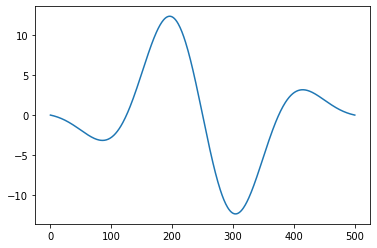

In [382]:
# If we don't copy when assigning to filt, it gets bound / referenced and gets modified on repeat run
d = np.sum(all_filts[scale,ifilt], axis=0)
plt.plot(d)

Latency to peak: [0.0215]
filt len: 477
0.059625000000000004
(159, 1818)
(160, 1818)
(160, 1818)


/tmp/ipykernel_710738/3382354675.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_710738/3382354675.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
/tmp/ipykernel_710738/3382354675.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecate

ValueError: Cannot achieve firing rate above 1000.0 with these absolute and relative refractory properties

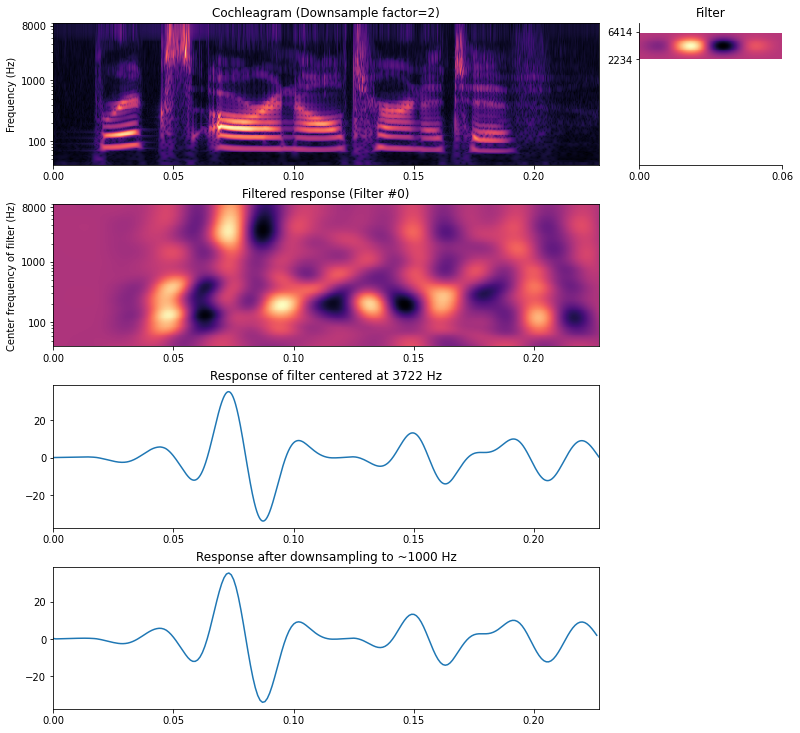

In [29]:
# Because padding is not plotted, do not choose a filter that extends past the edge
show_filters(pyramid, x_step_base, y_step_base, scale=1, ifilt=0, jfilt=133, scx=16)

In [288]:
0.06/(1/16000)

960.0

Latency to peak: [0.0305  0.06175]
filt len: 495
0.061875
(159, 1818)
(160, 1818)
(160, 1818)


/tmp/ipykernel_710738/3382354675.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_710738/3382354675.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
/tmp/ipykernel_710738/3382354675.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecate

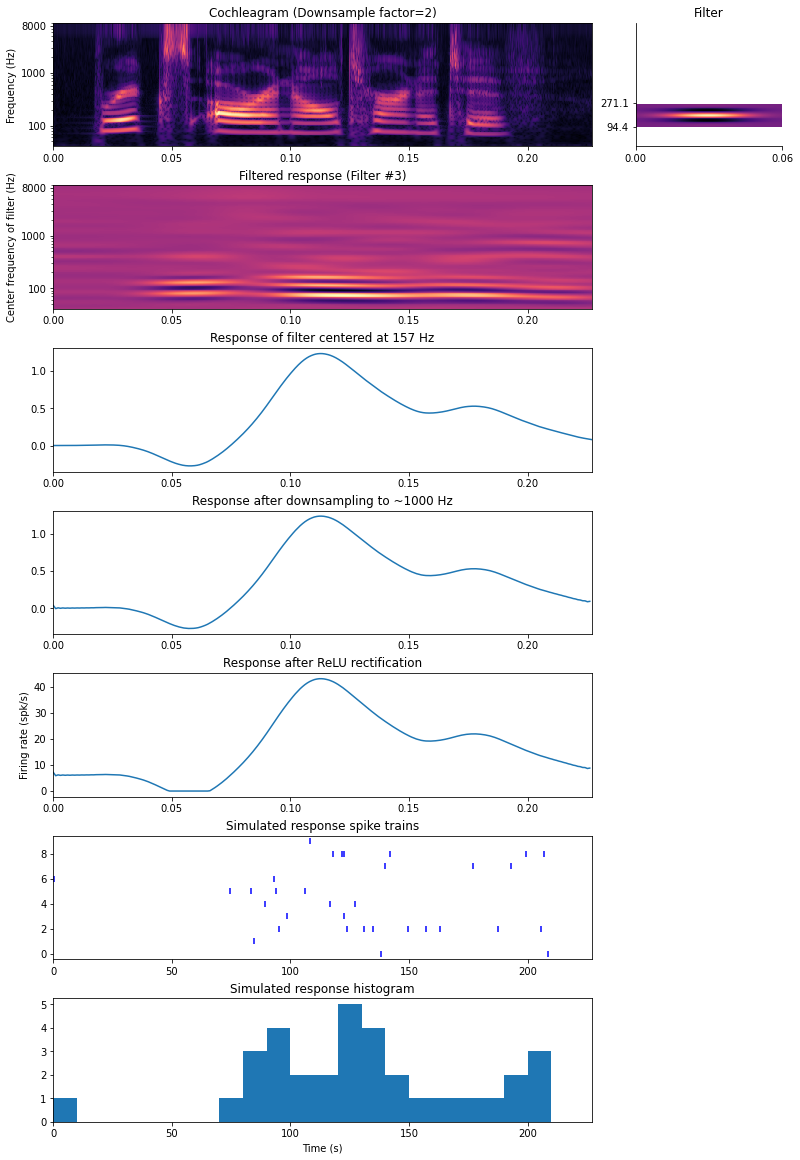

In [30]:
show_filters(pyramid, x_step_base, y_step_base, scale=1, ifilt=3, jfilt=40, scx=16)

Latency to peak: [0.00175  0.001875 0.004625 0.00475  0.0075   0.010125 0.012625 0.015125
 0.0175   0.01975  0.022    0.02425  0.0265   0.026625 0.028875 0.029
 0.031375 0.0315   0.034    0.036625 0.03675  0.0395   0.039625 0.042375
 0.0425  ]
filt len: 392
0.049
(80, 909)
(80, 909)
(80, 909)


/tmp/ipykernel_710738/3382354675.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_710738/3382354675.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
/tmp/ipykernel_710738/3382354675.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecate

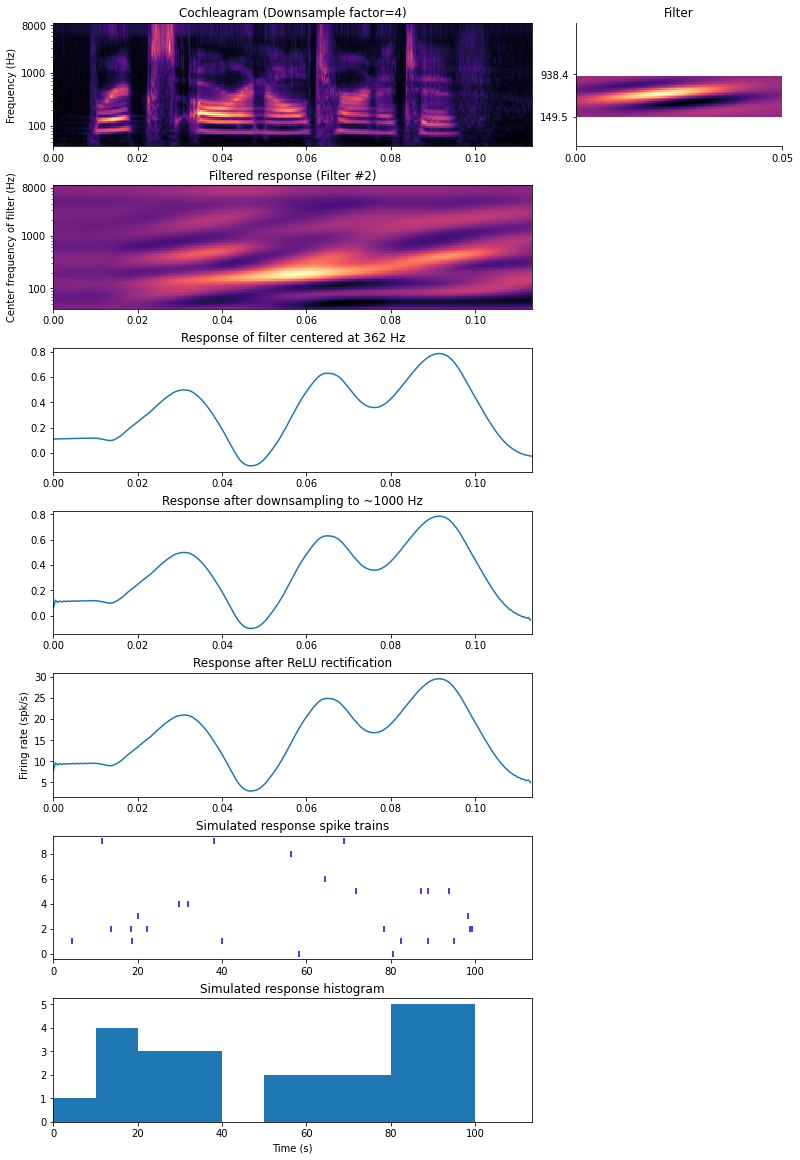

In [34]:
show_filters(pyramid, x_step_base, y_step_base, scale=2, ifilt=2, jfilt=32, scx=8)

# For rising filter why doesn’t convolution flip the filter? 
# Actually flipped twice – left right, then up down

In [33]:
x_step_base=0.00025

Latency to peak: [0.007  0.0075 0.0185 0.019  0.03   0.0405 0.0505 0.0605 0.07   0.079
 0.088  0.097  0.106  0.1065 0.1155 0.116  0.1255 0.126  0.136  0.1465
 0.147  0.158  0.1585 0.1695 0.17  ]
filt len: 392
0.196
(80, 909)
(80, 909)
(80, 909)


/tmp/ipykernel_155291/3382354675.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_155291/3382354675.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
/tmp/ipykernel_155291/3382354675.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecate

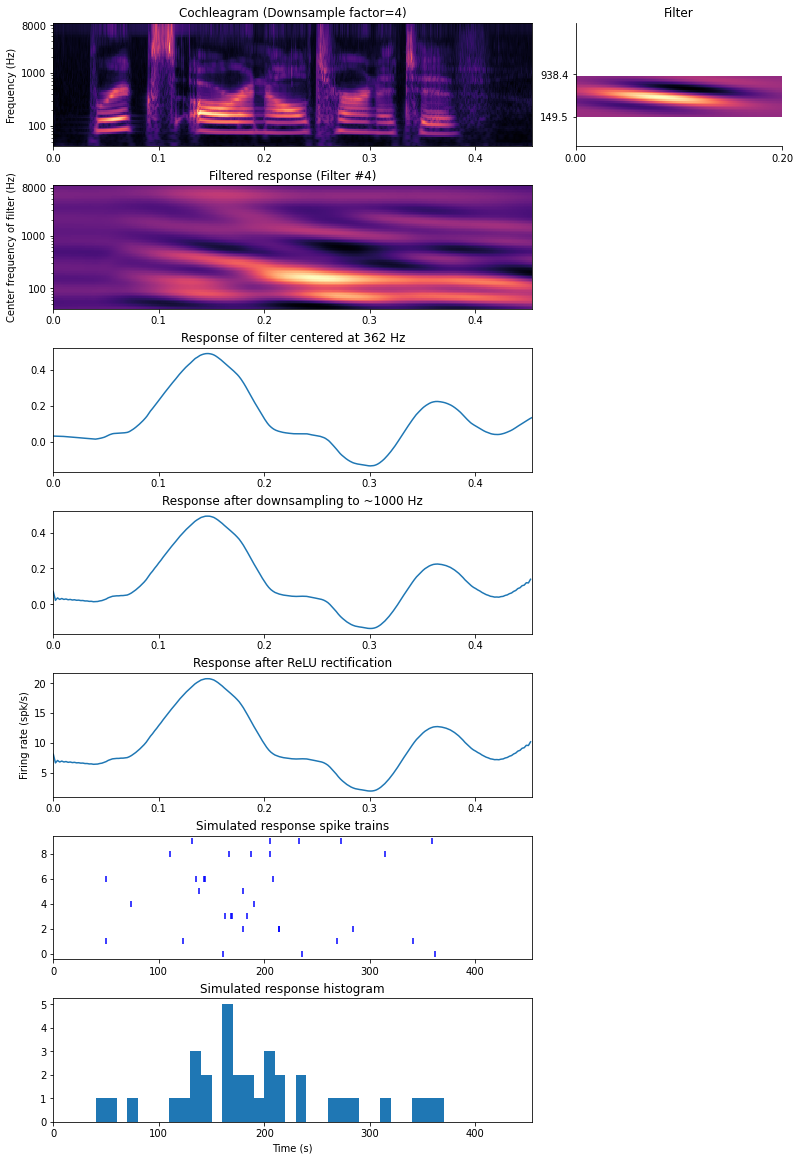

In [114]:
show_filters(pyramid, x_step_base, y_step_base, scale=2, ifilt=4, jfilt=32, scx=8)

In [99]:
#x_step_base = 0.00025
x_step_base = 0.001

Latency to peak: [0.0026875]
filt len: 477
0.0074531250000000005
(317, 3636)
(317, 3636)
(317, 3636)


/tmp/ipykernel_155291/3382354675.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_155291/3382354675.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
/tmp/ipykernel_155291/3382354675.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecate

NameError: name 'reLU' is not defined

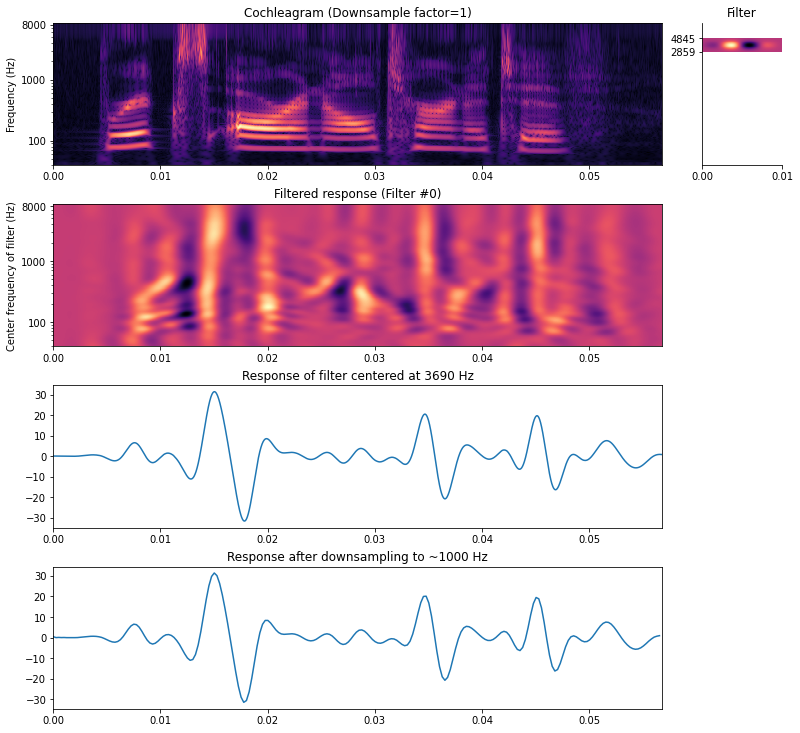

In [100]:


show_filters(pyramid, x_step_base, y_step_base, scale=0, ifilt=0, jfilt=266, scx=16)

In [131]:
xl = (-0.09083747936158504, 1.907587066593286)
list(xl)
ax.set_xlim(np.array(xl)*1000)
#ax.set_xlim([0,1.75])

(-90.83747936158504, 1907.587066593286)

In [162]:
freqs = np.array([(a + b) / 2 for a, b in zip(log_freqs[::2], log_freqs[1::2])])
freqs.shape
freqs2 = np.array([(a + b) / 2 for a, b in zip(freqs[::2], freqs[1::2])])

print(np.log(freqs[1])-np.log(freqs[0]))
scale = 1
y_sr = y_SR_base*(2**scale)
y_sr
print(y_sr)

freqs2.shape
freqs2

0.03401949352441447
0.0340194935244158


array([  41.04113675,   43.93072169,   47.02375376,   50.33455705,
         53.87846421,   57.67188738,   61.73239424,   66.07878937,
         70.73120131,   75.71117581,   81.04177557,   86.74768708,
         92.85533493,   99.39300418,  106.39097136,  113.88164471,
        121.89971418,  130.4823122 ,  139.66918553,  149.50287942,
        160.02893458,  171.29609812,  183.3565493 ,  196.26614114,
        210.08465913,  224.87609806,  240.70895842,  257.65656361,
        275.7973995 ,  295.21547795,  316.00072582,  338.24940146,
        362.06454049,  387.55643296,  414.84313411,  444.05101112,
        475.31532827,  508.78087345,  544.60262859,  582.94648747,
        623.99002395,  667.92331432,  714.94981761,  765.28731779,
        819.16893234,  876.84419186,  938.58019566, 1004.66284874,
       1075.39818579, 1151.11378853, 1232.16030271, 1318.91306203,
       1411.77382632, 1511.17264212, 1617.5698343 , 1731.4581378 ,
       1853.36497961, 1983.85492126, 2123.53227342, 2273.04389

In [161]:
scale = 2
freq_start = np.mean(np.log(log_freqs[0:2**scale]))
freqs = np.exp(np.arange(freq_start,freq_start+y_sr*(resp_norm.shape[0]), y_sr))
freqs = freqs[:resp_norm.shape[0]]
print(freqs.shape)
freqs

(80,)


array([  41.03371617,   43.92277865,   47.01525147,   50.32545614,
         53.86872253,   57.66145981,   61.7212325 ,   66.06684177,
         70.71841252,   75.69748659,   81.02712254,   86.73200237,
         92.8385459 ,   99.37503308,  106.37173498,  113.86105395,
        121.87767369,  130.4587199 ,  139.64393216,  149.47584804,
        160.        ,  171.26512635,  183.32339689,  196.23065457,
        210.04667406,  224.83543857,  240.66543621,  257.60997713,
        275.74753301,  295.16210051,  315.94359023,  338.18824312,
        361.99907618,  387.48635949,  414.76812698,  443.97072295,
        475.22938726,  508.68888159,  544.50415985,  582.84108584,
        623.8772013 ,  667.80254816,  714.82054867,  765.1489474 ,
        819.0208197 ,  876.68565105,  938.41049246, 1004.48119724,
       1075.20374475, 1150.90565746, 1231.93751775, 1318.67459145,
       1411.51856573, 1510.89940939, 1617.27736405, 1731.14507559,
       1853.02987562, 1983.49622359, 2123.1483209 , 2272.63290

In [136]:
log_freqs
#log_freqs.shape

array([  40.        ,   40.68620945,   41.38419098,   42.09414656,
         42.81628159,   43.55080501,   44.29792936,   45.05787081,
         45.83084922,   46.61708827,   47.41681543,   48.2302621 ,
         49.05766364,   49.89925945,   50.75529304,   51.62601208,
         52.51166851,   53.41251859,   54.32882297,   55.26084676,
         56.20885964,   57.17313591,   58.15395456,   59.15159939,
         60.16635905,   61.19852716,   62.24840235,   63.3162884 ,
         64.40249428,   65.50733429,   66.63112808,   67.77420083,
         68.93688325,   70.11951177,   71.32242856,   72.54598167,
         73.79052513,   75.05641902,   76.34402962,   77.65372948,
         78.98589756,   80.34091929,   81.71918674,   83.1210987 ,
         84.54706078,   85.99748558,   87.47279276,   88.97340919,
         90.49976904,   92.05231396,   93.63149316,   95.23776354,
         96.87158987,   98.53344488,  100.22380941,  101.94317254,
        103.69203175,  105.47089305,  107.28027113,  109.12068

In [14]:
def gabor3(sigma_x, theta, Lambda, psi, sigma_y, x_step, y_step, bounds):
    """Gabor feature extraction.
    Note sigma_x and sigma_y are more like the dimension of the sinusoid and the perpendicular dimension, not necessarily x and y"""

    # Bounding box
    if bounds == 'auto':
        nstds = 3  # Number of standard deviation sigma
        xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
        ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
        xmin = -xmax
        ymin = -ymax
    elif len(bounds)==4:
        xmin, xmax, ymin, ymax = bounds
    
    (x, y) = np.meshgrid(np.arange(xmin, xmax + x_step, x_step), np.arange(ymin, ymax + y_step, y_step), indexing='ij')

    gauss = np.exp(-.5 * ((x*np.cos(theta) + y*np.sin(theta))**2/sigma_x**2 + 
                          (-x*np.sin(theta) + y*np.cos(theta))**2/sigma_y**2))
    wave = np.cos(2*np.pi/Lambda*(x*np.cos(theta)+y*np.sin(theta))+psi)
    gb = gauss * wave
    return gb, x, y

In [192]:
# Keep Gaussian on axis, but rotate sinusoid, separate temporal and spectral phase?


def gabor4(b, sigma_y, theta, Lambda, psi, x_step, y_step, origin, bounds):

    """Gabor feature extraction.
    Note sigma_x and sigma_y are more like the dimension of the sinusoid and the perpendicular dimension, not necessarily x and y"""

    # Bounding box
    if bounds == 'auto':
        nstds = 3  # Number of standard deviation sigma
        xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
        ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
        xmin = -xmax
        ymin = -ymax
    elif len(bounds)==4:
        xmin, xmax, ymin, ymax = np.array(bounds)+np.array([origin[0], origin[0], origin[1], origin[1]])
    
    (x, y) = np.meshgrid(np.arange(xmin, xmax + x_step, x_step), np.arange(ymin, ymax + y_step, y_step), indexing='ij')

    #gauss = np.exp(-.5 * (x**2/sigma_x**2 + y**2/sigma_y**2))
    x2 = x-origin[0]
    y2 = y-origin[1]
    f = 1/(Lambda * np.cos(theta))
    env = (f*x2)**2*np.exp(-b*f*x2) * np.exp(-.5 * (y2**2/sigma_y**2))
    wave = np.cos(2*np.pi/Lambda*(x2*np.cos(theta)+y2*np.sin(theta))+psi)
    gb = env * wave
    
    return gb, x, y

theta: 0.0


/tmp/ipykernel_666879/573108971.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xmin, xmax, ymin, ymax = np.array(bounds)+np.array([origin[0], origin[0], origin[1], origin[1]])
/tmp/ipykernel_666879/2890251612.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i,j].pcolormesh(x,y,g1)


theta: 0.049952776230082006
theta: 0.0
theta: 0.04987522665469264


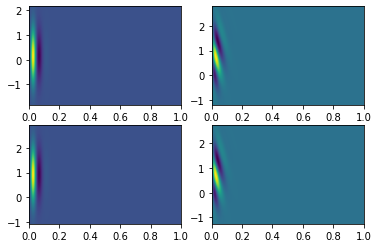

In [204]:
# Testing Gabor mixtures
from numpy import random

g = []

x_step = 0.001
y_step = 0.001

# In freq units
u0_list = np.random.normal(10, 0.01, size=2)
# u0_list = [0.22, 0.25, 0.27, 0.24]    # missing 0, handle separately
#v0_list = [0.5, 0.55, 0.6, 0.51]
v0_list = [0, 0.5]      # spectral
#v0_list = np.random.normal(0.5, 0.04, size=12)


psi = -np.pi/2    # -np.pi or -np.pi/2 or 0
sigma_s = 0.75
#sigma2 = 1.5
b = 7

fig, ax = plt.subplots(len(u0_list), len(v0_list))

for i,u0 in enumerate(u0_list):
    for j,v0 in enumerate(v0_list):
        if u0 == 0 and v0 == 0:
            continue
        if u0 != 0:
            theta = np.arctan(v0/u0)
        else: 
            theta = np.pi/2
        print('theta:',theta)

        Lambda = 1/np.linalg.norm([u0,v0])
        #sigma_t = Lambda/4  # was Lambda/2
        #sigma = Lambda/2
        #g1,x,y = gabor3(sigma, theta, Lambda, psi, sigma2, x_step, y_step, [-4,4,-6,6]) 
        #g1,x,y = gabor4(sigma_t, sigma_s, theta, Lambda, psi, x_step, y_step, [-4,4,-4,4])  
        # CAN ONLY USE POSITIVE X VALUES WITH GAMMATONE-LIKE ENVELOPE
        origin = [0,random.rand(1)]
        g1,x,y = gabor4(b, sigma_s, theta, Lambda, psi, x_step, y_step, origin, [0,1,-2,2])  
    
        # To create frequency offset, crop them?
        #min_rows = random.rand(len(u0_list), len(v0_list))*0.1*int(0.9*g1.shape[0])
        #min_row = int(random.rand(1)*0.2*g1.shape[1])
        #max_row = min_row+int(0.8*g1.shape[1])
        #print(min_row, max_row)
        ax[i,j].pcolormesh(x,y,g1)
        #g.append(g1[:, min_row:max_row])
        g.append(g1)
        #ax.axis('scaled')
#plt.show()



In [205]:
a = np.max(g1, axis=1)
c = np.argmax(a)
c*0.001

0.028

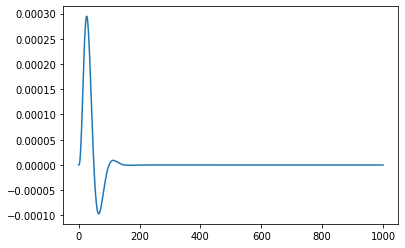

In [206]:
a = np.mean(g1, axis=1)

plt.plot(a)

/tmp/ipykernel_666879/2010661179.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,g_sum)


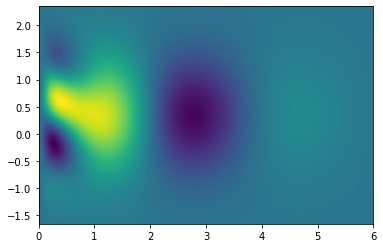

In [169]:
g_sum = sum(g)
plt.pcolormesh(x,y,g_sum)

In [8]:
G = np.fft.fft2(g1)

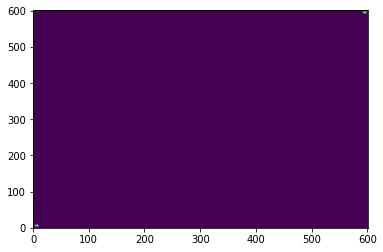

In [10]:
plt.pcolormesh(np.abs(G))


In [14]:
np.argmin(np.abs(G))

283991

In [ ]:
phase interpolation from pi/2 in time towards [0,-pi, or pi/2] in spectrum

Don't worry about scale - you can always interpolate onto right time scale


In [3]:
import scipy.io
mat = scipy.io.loadmat('/home/ping/Filternet_improvement/UCSF_STG_neuropixels_summary_stats.mat')
datastruct = mat['stg_np']
datastruct

array([[(array([[(array([[3900, 3940, 3940, 3980, 3980, 4020, 4020, 4060, 4220, 4220, 4300,
                        4340, 4420, 4420,  620, 4460,  660, 4540, 4540, 4540,  700, 4680,
                        4720, 4740, 4780, 4780, 4780, 1020, 4860, 1060, 1100, 1100, 5000,
                        5020, 5020, 5100, 1420, 1460, 5300, 1660, 5500, 5540, 1740, 1740,
                        1780, 1820, 1840, 1860, 1980, 1980, 2020, 2060, 2100, 2100, 2240,
                        2260, 2280, 2420, 2540, 2660, 2700, 2700, 2940, 3020, 3040, 3100,
                        3180, 3180, 3300, 3300, 3520, 3540, 3620, 3660, 3680, 3780, 3800,
                        3820, 4420,  680, 4540, 4740, 4980, 1220, 1760, 2060, 3340, 3420,
                        3540, 3760, 2060, 2620, 4340, 2240, 3660, 4980, 1880,  540, 4460,
                        2460, 2560, 3900,  700, 4620, 4740, 4960, 5000, 5420, 2620, 2660,
                        2860, 3300, 2400, 3340,  940, 4380, 2560]], dtype=uint16), array([[ 1.3303

In [4]:
datastruct['unit_info'][0,0][0,2]

(array([[7160, 7080, 6960, 6840, 6720, 6700, 6620, 6600, 6040, 5840, 5800,
        5800, 5460, 5440, 5280, 5220, 5160, 5120, 5080, 5080, 5040, 5000,
        4980, 4960, 4720, 4640, 4520, 4520, 4480, 4440, 4440, 4400, 4360,
        4240, 4200, 4200, 4200, 4180, 4160, 4120, 4040, 4040, 4040, 4020,
        4020, 4000, 3860, 3720, 3640, 3600, 3520, 3500, 3460, 3440, 3420,
        3400, 3320, 3280, 3180, 3160, 3120, 3040, 3000, 2920, 2740, 2740,
        2720, 2700, 2640, 2600, 2560, 2480, 2420, 2380, 2340, 2340, 2300,
        2300, 2280, 2260, 2240, 2220, 2180, 2120, 2120, 1480,  860,  820,
         740,  700,  540,  540,  500,  300,  260]], dtype=uint16), array([[ 0.33049027,  0.30549521,  0.91833712, 16.41435025,  3.97514071,
         0.81928261,  8.25762812,  0.48231214,  1.12014911,  0.31938136,
         2.01441691,  0.43880221,  0.41195566,  0.46379727,  1.17939666,
         0.76373803,  0.30549521,  1.65430285,  0.72393108,  1.85981781,
         1.4274958 ,  0.60080725,  0.92481732,  

In [206]:
datastruct.dtype
datastruct['strf_metrics'][0,0][0,0][5]    # Column ind3 best frequency? 

array([[0.00651042, 0.09765625, 0.0390625 , 0.01302083, 0.10416667,
        0.08463542, 0.2734375 , 0.01953125, 0.2734375 , 0.01302083,
        0.03255208, 0.13020833, 0.13020833, 0.16276042, 0.2734375 ,
        0.02604167, 0.09114583, 0.20182292, 0.09765625, 0.30598958,
        0.234375  , 0.26041667, 0.25390625, 0.26041667, 0.20833333,
        0.13020833, 0.13020833, 0.04557292, 0.14973958, 0.04557292,
        0.06510417, 0.26041667, 0.        , 0.16927083, 0.05859375,
        0.09765625, 0.01302083, 0.04557292, 0.03255208, 0.03255208,
        0.03255208, 0.29947917, 0.28645833, 0.09114583, 0.24088542,
        0.01953125, 0.01302083, 0.00651042, 0.24739583, 0.40364583,
        0.37109375, 0.04557292, 0.38411458, 0.15625   , 0.01302083,
        0.        , 0.04557292, 0.00651042, 0.01302083, 0.04557292,
        0.32552083, 0.13671875, 0.09114583, 0.02604167, 0.33203125,
        0.31901042, 0.15625   , 0.26041667, 0.14322917, 0.05859375,
        0.76171875, 0.16927083, 0.15625   , 0.19

In [185]:
import csv

with open('/home/ping/Filternet_improvement/STRF_cfs.csv', newline='') as csvfile:
    bf_centers = np.array(list(csv.reader(csvfile))[0]).astype(float)

print(bf_centers)
len(bf_centers)

[   0.      22.689   46.114   70.297   95.265  121.04   147.65   175.13
  203.49   232.78   263.01   294.23   326.45   359.72   394.07   429.53
  466.15   503.94   542.97   583.26   624.85   667.79   712.13   757.9
  805.15   853.94   904.31   956.31  1010.    1065.4   1122.6   1181.7
 1242.7   1305.7   1370.7   1437.8   1507.1   1578.6   1652.5   1728.7
 1807.5   1888.7   1972.7   2059.3   2148.7   2241.1   2336.4   2434.8
 2536.4   2641.3   2749.6   2861.4   2976.9   3096.    3219.1   3346.1
 3477.2   3612.6   3752.4   3896.7   4045.7   4199.6   4358.4   4522.3
 4691.6   4866.4   5046.8   5233.1   5425.4   5623.9   5828.9   6040.5
 6259.    6484.5   6717.4   6957.8   7206.    7462.3   7726.9   8000.   ]


80

In [6]:
from mat4py import loadmat 

data = loadmat('/home/ping/Filternet_improvement/UCSF_STG_neuropixels_summary_stats.mat')
depth_list = data['stg_np']['unit_info']['depth']

flat_list = [item for sublist in depth_list for item in sublist]
len(flat_list)


614

(array([ 2.,  0.,  0.,  0.,  1.,  5.,  3.,  2.,  3.,  4.,  5.,  3.,  3.,
         2.,  3.,  3.,  1.,  4.,  9.,  3.,  1.,  6.,  4., 10., 11.,  4.,
        11.,  3.,  2.,  5.,  2.,  0.,  1.,  3.,  1.,  7.,  2.,  5.,  5.,
        12.]),
 array([0.51457317, 0.65975705, 0.80494092, 0.95012479, 1.09530867,
        1.24049254, 1.38567641, 1.53086028, 1.67604416, 1.82122803,
        1.9664119 , 2.11159578, 2.25677965, 2.40196352, 2.5471474 ,
        2.69233127, 2.83751514, 2.98269901, 3.12788289, 3.27306676,
        3.41825063, 3.56343451, 3.70861838, 3.85380225, 3.99898613,
        4.14417   , 4.28935387, 4.43453775, 4.57972162, 4.72490549,
        4.87008936, 5.01527324, 5.16045711, 5.30564098, 5.45082486,
        5.59600873, 5.7411926 , 5.88637648, 6.03156035, 6.17674422,
        6.32192809]),
 <BarContainer object of 40 artists>)

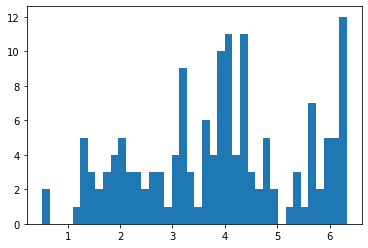

In [8]:
strf_width = data['stg_np']['strf_metrics']['fwhm']
plt.hist(strf_width, bins =40)
# Does last min absorb all values above 6.3?

(array([13.,  1.,  4.,  1.,  6.,  1.,  5., 11., 18., 30., 19., 22.,  4.,
         1.,  4.,  0.,  3.,  1.,  0.,  7.]),
 array([-300., -280., -260., -240., -220., -200., -180., -160., -140.,
        -120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,
          60.,   80.,  100.]),
 <BarContainer object of 20 artists>)

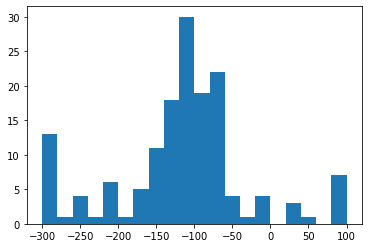

In [178]:
bf_latency = np.array(data['stg_np']['strf_metrics']['bf_latency']).astype(int)
strf_t = np.linspace(100, -400, 51)
plt.hist(strf_t[bf_latency-1], bins =20) 
# most latencies falling between 50 and 150 ms

(array([ 3.,  4., 12., 18., 26., 26., 24., 20.,  6., 12.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 <BarContainer object of 10 artists>)

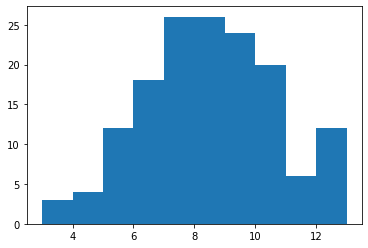

In [182]:
num_peaks = data['stg_np']['strf_metrics']['num_peaks']
plt.hist(num_peaks)

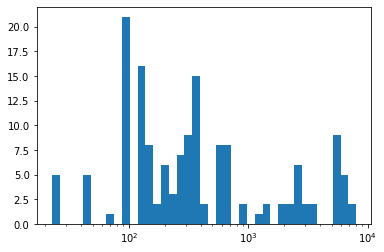

In [200]:
bf = np.array(data['stg_np']['strf_metrics']['bf']).astype(int)
# min value of bf is 2, max is 80
logbins = np.logspace(np.log10(bf_centers[1]),np.log10(bf_centers[-1]),int(len(bf_centers)/2))
plt.hist(bf_centers[bf-1], bins=logbins)
plt.xscale('log')

In [197]:
len(bf_centers)

80

(array([25., 18., 12., 13.,  8.,  6., 10., 19., 14.,  5.,  5.,  2.,  2.,
         2.,  5.,  2.,  1.,  1.,  0.,  1.]),
 array([0.02442599, 0.33952125, 0.65461651, 0.96971177, 1.28480703,
        1.5999023 , 1.91499756, 2.23009282, 2.54518808, 2.86028334,
        3.1753786 , 3.49047386, 3.80556913, 4.12066439, 4.43575965,
        4.75085491, 5.06595017, 5.38104543, 5.69614069, 6.01123596,
        6.32633122]),
 <BarContainer object of 20 artists>)

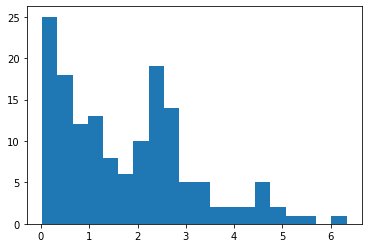

In [190]:
bTMF = data['stg_np']['strf_metrics']['best_temp_mod']
plt.hist(bTMF, bins = 20)

(array([42., 31., 29., 11., 14., 16.,  4.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.05696615, 0.11393229, 0.17089844, 0.22786458,
        0.28483073, 0.34179688, 0.39876302, 0.45572917, 0.51269531,
        0.56966146, 0.6266276 , 0.68359375, 0.7405599 , 0.79752604,
        0.85449219, 0.91145833, 0.96842448, 1.02539062, 1.08235677,
        1.13932292]),
 <BarContainer object of 20 artists>)

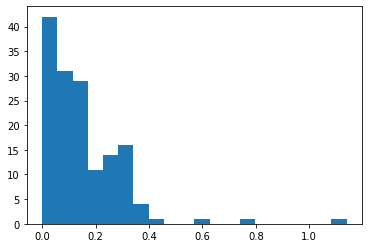

In [204]:
bSMF = data['stg_np']['strf_metrics']['best_spec_mod']
plt.hist(bSMF, bins = 20)

In [44]:
x = np.array([[1,2,3],[3,4,2]])
y = x[np.newaxis]
y.shape

(1, 2, 3)

In [113]:
a = np.array([[1.0,2,3],[4,5,-6]])
a

array([[ 1.,  2.,  3.],
       [ 4.,  5., -6.]])

In [114]:
np.where(a>0)

(array([0, 0, 0, 1, 1]), array([0, 1, 2, 0, 1]))

In [108]:
np.sum(a*[[1,1,1],[1,1,-1]])

0.9999999999999999

In [110]:
1000/15/4

16.666666666666668

In [13]:
str(5)

'5'